### Import

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

Dataset設定與前處理：

In [2]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
nb_classes=10
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train 切出 X_train, X_val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1001, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_train[:10])

11490434/11490434 [==============================] - 0s 0us/step
(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)
(48000,) (12000,) (10000,)
[2 0 0 4 3 3 7 5 7 7]


In [3]:
print(X_train.dtype)
print(X_train.shape)
print(X_train[0, :10, :10])

uint8
(48000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 123]
 [  0   0   0   0   0   0   0   0   0 214]
 [  0   0   0   0   0   0   0   0   0 214]
 [  0   0   0   0   0   0   0   0  70 243]
 [  0   0   0   0   0   0   0   0  94 253]]


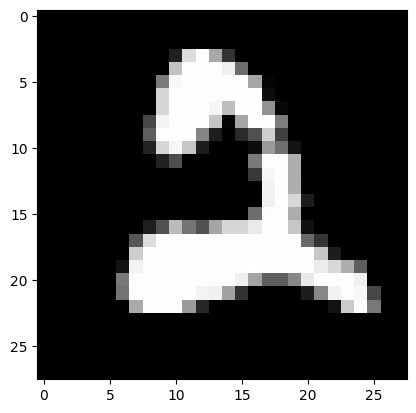

Label:  2


In [4]:
plt.imshow(X_train[0],  cmap="gray")    # show first number in the dataset
plt.show()
print('Label: ', y_train[0])

In [5]:
X_train.shape

(48000, 28, 28)

In [6]:
X_train = np.expand_dims(X_train, axis=-1)
X_train.shape

(48000, 28, 28, 1)

In [8]:
X_val = np.expand_dims(X_val, axis=-1)
X_val.shape

(12000, 28, 28, 1)

In [7]:
X_test = np.expand_dims(X_test, axis=-1)
X_test.shape

(10000, 28, 28, 1)

In [9]:
# Convert to tf.data.Dataset.from_tensor_slices
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train.reshape(-1)) # reshape(-1): 2-d to 1-d
y_val = tf.data.Dataset.from_tensor_slices(y_val.reshape(-1))
y_test = tf.data.Dataset.from_tensor_slices(y_test.reshape(-1))

In [10]:
# Convert to tf.data.Dataset.zip
train_data = tf.data.Dataset.zip({"x": X_train, "y": y_train})
val_data = tf.data.Dataset.zip({"x": X_val, "y": y_val})
test_data = tf.data.Dataset.zip({"x": X_test, "y": y_test})

In [11]:
print(train_data)

<_ZipDataset element_spec={'x': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'y': TensorSpec(shape=(), dtype=tf.uint8, name=None)}>


In [12]:
# 影像資料：將輸入資料做標準化，全部除以255，將像素值縮放到0~1之間。
# 標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。

def parse_fn(dataset):
    x = tf.cast(dataset['x'], tf.float32) / 255. # casts a tensor to new type
    y = tf.one_hot(dataset['y'], nb_classes) # one-hot
    return x, y

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小

train_data = train_data.shuffle(buffer_size=10000)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
val_data = val_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1（全連接神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為28x28x1)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄30%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [14]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0   

創建紀錄檔目錄

In [15]:
model_dir = 'lab3-3-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

建立Callback function：

In [16]:
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('lab3-3-logs', 'model-1')
os.makedirs(log_dir)
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-1.hdf5")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
es = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=5)

設定訓練使用的優化器、損失函數和指標函數

In [17]:
model_1.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [18]:
history_1 = model_1.fit(train_data,
                        validation_data=val_data,
                        epochs=100,
                        callbacks=[model_cbk, model_mckp, es])

Epoch 1/100
750/750 [==============================] - 12s 6ms/step - loss: 0.4166 - categorical_accuracy: 0.8741 - val_loss: 0.1694 - val_categorical_accuracy: 0.9508
Epoch 2/100
  6/750 [..............................] - ETA: 8s - loss: 0.1899 - categorical_accuracy: 0.9401 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 6s 8ms/step - loss: 0.1733 - categorical_accuracy: 0.9489 - val_loss: 0.1260 - val_categorical_accuracy: 0.9623
Epoch 3/100
750/750 [==============================] - 6s 8ms/step - loss: 0.1293 - categorical_accuracy: 0.9617 - val_loss: 0.1190 - val_categorical_accuracy: 0.9647
Epoch 4/100
750/750 [==============================] - 4s 6ms/step - loss: 0.1029 - categorical_accuracy: 0.9688 - val_loss: 0.1059 - val_categorical_accuracy: 0.9701
Epoch 5/100
750/750 [==============================] - 5s 6ms/step - loss: 0.0879 - categorical_accuracy: 0.9733 - val_loss: 0.1055 - val_categorical_accuracy: 0.9698
Epoch 6/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0734 - categorical_accuracy: 0.9773 - val_loss: 0.1000 - val_categorical_accuracy: 0.9700
Epoch 7/100
750/750 [==============================] - 4s 6ms/step - loss: 0.0631 - categorical_accuracy: 0.9807 - val_loss: 0.1018 - val_categorical_accuracy: 0.9712
Epoch 8/10

驗證在測試集上：

In [19]:
loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 4ms/step - loss: 0.1023 - categorical_accuracy: 0.9741

Model-1 Accuracy: 0.9740999937057495%


### 訓練Model-2（卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [20]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 1296)              0         
                                                           

建立Callback function：

In [21]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab3-3-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-2.hdf5")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
es = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=5)

設定訓練使用的優化器、損失函數和指標函數

In [22]:
model_2.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [23]:
history_2 = model_2.fit(train_data,
                        validation_data=val_data,
                        epochs=100,
                        callbacks=[model_cbk, model_mckp, es])

Epoch 1/100
750/750 [==============================] - 14s 8ms/step - loss: 0.9630 - categorical_accuracy: 0.6318 - val_loss: 0.1796 - val_categorical_accuracy: 0.9528
Epoch 2/100
750/750 [==============================] - 7s 9ms/step - loss: 0.5971 - categorical_accuracy: 0.7666 - val_loss: 0.1161 - val_categorical_accuracy: 0.9691
Epoch 3/100
750/750 [==============================] - 5s 7ms/step - loss: 0.5321 - categorical_accuracy: 0.7889 - val_loss: 0.0911 - val_categorical_accuracy: 0.9774
Epoch 4/100
750/750 [==============================] - 6s 8ms/step - loss: 0.4866 - categorical_accuracy: 0.8070 - val_loss: 0.0770 - val_categorical_accuracy: 0.9802
Epoch 5/100
750/750 [==============================] - 6s 8ms/step - loss: 0.4634 - categorical_accuracy: 0.8128 - val_loss: 0.0699 - val_categorical_accuracy: 0.9815
Epoch 6/100
750/750 [==============================] - 6s 8ms/step - loss: 0.4517 - categorical_accuracy: 0.8175 - val_loss: 0.0724 - val_categorical_accuracy: 0.98

驗證在測試集上：

In [24]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 [==============================] - 4s 28ms/step - loss: 0.0648 - categorical_accuracy: 0.9844

Model-2 Accuracy: 0.9843999743461609%


### 影像增強(Image Augmentation)

### Dataset 設定 (Augmentation)

In [33]:
# Convert to tf.data.Dataset.from_tensor_slices
train_data = tf.data.Dataset.zip({"x": X_train, "y": y_train})
# val_data: same as in model_1
# test_data: same as in model_1

In [32]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x

def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['x'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    # x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x) # only 1 channel cannot apply
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['y'], 10)
    return x, y

In [34]:
# 打散資料集
train_data = train_data.shuffle(buffer_size=10000)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# val_data: same as in model_1
# test_data: same as in model_1

### 訓練Model-3（使用影增強方法訓練卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [28]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構

Model: "model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 16)          4624      
                                                                 
 flatten_2 (Flatten)         (None, 1296)              0         
                                                           

建立Callback function：

In [29]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab3-3-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-3.hdf5")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
es = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=5)

設定訓練使用的優化器、損失函數和指標函數

In [30]:
model_3.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [35]:
history_3 = model_3.fit(train_data,
                        validation_data=val_data,
                        epochs=150,
                        callbacks=[model_cbk, model_mckp, es])

Epoch 1/150
750/750 [==============================] - 12s 15ms/step - loss: 1.5170 - categorical_accuracy: 0.4665 - val_loss: 0.5668 - val_categorical_accuracy: 0.8568
Epoch 2/150
750/750 [==============================] - 15s 20ms/step - loss: 1.1748 - categorical_accuracy: 0.5874 - val_loss: 0.4052 - val_categorical_accuracy: 0.9162
Epoch 3/150
750/750 [==============================] - 12s 15ms/step - loss: 1.0500 - categorical_accuracy: 0.6267 - val_loss: 0.3293 - val_categorical_accuracy: 0.9119
Epoch 4/150
750/750 [==============================] - 14s 18ms/step - loss: 0.9811 - categorical_accuracy: 0.6509 - val_loss: 0.3011 - val_categorical_accuracy: 0.9398
Epoch 5/150
750/750 [==============================] - 11s 15ms/step - loss: 0.9388 - categorical_accuracy: 0.6654 - val_loss: 0.2573 - val_categorical_accuracy: 0.9422
Epoch 6/150
750/750 [==============================] - 11s 15ms/step - loss: 0.9038 - categorical_accuracy: 0.6792 - val_loss: 0.2486 - val_categorical_acc

驗證在測試集上：

In [36]:
loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))

157/157 [==============================] - 9s 57ms/step - loss: 0.1451 - categorical_accuracy: 0.9659

Model-3 Accuracy: 0.9659000039100647%


### 比較三種網路的訓練結果

讀取各自最佳的網路權重：

In [37]:
model_1.load_weights('lab3-3-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab3-3-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab3-3-logs/models/Best-model-3.hdf5')

驗證在測試集數據上：

In [38]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.1521 - categorical_accuracy: 0.9652


顯示預測的損失值與準確度結果：

In [39]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,0.100412,0.9741
1,0.054353,0.9846
2,0.152078,0.9652
